In [2]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn import model_selection
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [25]:
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

def normalizar(X):
    min_values = X.min(axis=0)
    max_values = X.max(axis=0)
    X = (X - min_values) / (max_values - min_values)
    return X

# Leitura da instância e atribuição do X e do Y

In [49]:
data = pd.read_csv('instancias modelos/dataset_2T23_22.csv', index_col=0)
data

,1T_Dívida Líquida,1T_EBIT,1T_Lucro Líquido,1T_ROE,1T_Receita Líquida,2T_Dívida Líquida,2T_EBIT,2T_Lucro Líquido,2T_ROE,2T_Receita Líquida,Classificação
Empresa,,,,,,,,,,,
PETR4 - 2022,1.898480e+11,6.539800e+10,4.478300e+10,10.26,1.416410e+11,1.803670e+11,9.643400e+10,5.448400e+10,13.23,1.709600e+11,1
OIBR3 - 2022,2.854196e+10,-3.693700e+08,1.783950e+09,172.14,2.486940e+09,1.616768e+10,-6.114000e+08,-3.206600e+08,-41.52,2.579520e+09,1
B3SA3 - 2022,-5.093250e+09,1.430770e+09,1.101040e+09,5.05,2.284700e+09,-2.477130e+09,1.399600e+09,1.092280e+09,5.29,2.241630e+09,1
ITSA4 - 2022,4.888000e+09,4.167000e+09,3.859000e+09,5.67,2.131000e+09,5.137000e+09,3.270000e+09,3.181000e+09,4.56,2.214000e+09,1
ABEV3 - 2022,-1.124731e+10,4.162330e+09,3.528840e+09,4.32,1.843915e+10,-1.246893e+10,4.034080e+09,3.064050e+09,3.44,1.798900e+10,1
...,...,...,...,...,...,...,...,...,...,...,...
BAHI3 - 2023,1.771930e+08,-7.610000e+06,-1.787200e+07,-30.31,8.677900e+07,1.673060e+08,1.138000e+06,-1.412700e+07,-22.00,1.009340e+08,0
NEXP3 - 2023,4.833700e+07,-1.329800e+07,-1.784300e+07,-18.42,3.006600e+07,5.018700e+07,2.646400e+07,2.987100e+07,-23.20,3.742000e+07,0
EMAE4 - 2023,-4.473750e+08,1.038000e+06,1.888200e+07,1.65,1.375520e+08,-4.688340e+08,1.028100e+07,3.784800e+07,3.39,1.387540e+08,0


In [50]:
print(data['Classificação'].value_counts())
#Retire 45 linhas de classificacao = 0
data = data.drop(data[data.Classificação == 0].sample(45).index)
data['Classificação'].value_counts()

Classificação
0    208
1    163
Name: count, dtype: int64


Classificação
1    163
0    163
Name: count, dtype: int64

In [51]:
X = np.array(data.drop(['Classificação'], axis = 1))
Y = np.array(data['Classificação'])
RANDOM_STATE = 3
BATCH_SIZE = 32
# Normalização
X = padronizar_normal(X)

### Separando em dados de treino e teste

In [52]:
# Separando os dados de treino e teste
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state=RANDOM_STATE,test_size=0.2)
# Separando os dados de treino em treino e validação
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, random_state=RANDOM_STATE,test_size=0.2)

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_val:', X_val.shape)
print('Y_val:', Y_val.shape)

In [54]:
# Encontrando o numero de neuronios na camada escondida usando a dimensão vc
num_neuronios = (X_train.shape[0] - 10)/(10*(X_train.shape[1] + 2))
num_neuronios

1.65

# Utilizando o K-fold para checar se existe overfitting e o modelo

In [ ]:
# Introduzindo o k-fold, com k=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accuracies_train = []
accuracies_val = []
history_list = []
tamanho_history_history_loss_list = []
i = 0
for index_treino, index_val in kfold.split(X_train, Y_train):
    i += 1
    X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
    Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

    # Criando a rede neural
    model = Sequential()
    # Adicionando neurônios em uma camada oculta
    model.add(Dense(2, input_dim=10, kernel_initializer='normal', activation='gelu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

    # adicionando a taxa de aprendizado
    learning_rate = 0.001  

    # Criando um otimizador Adam com a taxa de aprendizado desejada
    otimizador = optimizers.Adam(learning_rate=learning_rate)

    # Compilando o modelo
    model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])


    #Treinando o modelo
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=1)
    history_list.append(history)
    tamanho_history_history_loss_list.append(len(history.history['loss']))

    # Avalia o modelo
    _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)

    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento', 'Validacao'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
    print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
       

# Calcula a acuracia media
acuracia_media_treino = np.mean(accuracies_train)
acuracia_media_validacao = np.mean(accuracies_val)

# Historico com valores medios dos folds
history_train_loss_avg_list = []
history_val_losso_avg_list = []

for epoca in range(max(tamanho_history_history_loss_list)):
    list_valores_loss_train = []
    list_valores_loss_val = []
    for j in range(len(history_list)):
        if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
            list_valores_loss_train.append(history_list[j].history['loss'][epoca])
            list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
    history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
    history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

loss_medio_treino = np.mean(history_train_loss_avg_list)
loss_medio_val = np.mean(history_val_losso_avg_list)

plt.plot(history_train_loss_avg_list)
plt.plot(history_val_losso_avg_list)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

- Nota-se que ocorreu overfitting e que a acurácia está baixa, além de uma perda alta. Isso significa que o modelo não está conseguindo aprender com o passar das épocas.

# Forçando o overfitting

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4274 - loss: 0.6948 - val_accuracy: 0.5238 - val_loss: 0.6748
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5762 - loss: 0.6772 - val_accuracy: 0.5238 - val_loss: 0.6657
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5770 - loss: 0.6758 - val_accuracy: 0.5238 - val_loss: 0.6591
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5738 - loss: 0.6758 - val_accuracy: 0.5476 - val_loss: 0.6539
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5845 - loss: 0.6614 - val_accuracy: 0.5714 - val_loss: 0.6484
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6068 - loss: 0.6531 - val_accuracy: 0.5476 - val_loss: 0.6439
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6133 - loss: 0.6532 - val_accuracy: 0.5238 - val_loss: 0.6446
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6286 - loss: 0.6461 - val_accuracy: 0.5238 - val_loss: 0

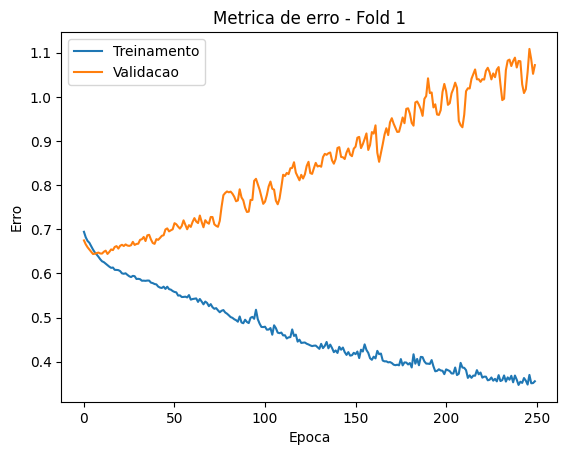

--> Acuracia (treino): 0.8554
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.2840
--> val_loss - train_loss = 0.7163

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5136 - loss: 0.6897 - val_accuracy: 0.5952 - val_loss: 0.6789
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5498 - loss: 0.6734 - val_accuracy: 0.5952 - val_loss: 0.6724
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5707 - loss: 0.6742 - val_accuracy: 0.6429 - val_loss: 0.6691
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5299 - loss: 0.6667 - val_accuracy: 0.6190 - val_loss: 0.6654
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5679 - loss: 0.6562 - val_accuracy: 0.6190 - val_loss: 0.6583
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5842 - loss: 0.6410 - val_accuracy: 0.5952 - val_loss: 0.6512
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6114 - loss: 0.6468 - val_accuracy: 0.5952 - val_loss: 0.650

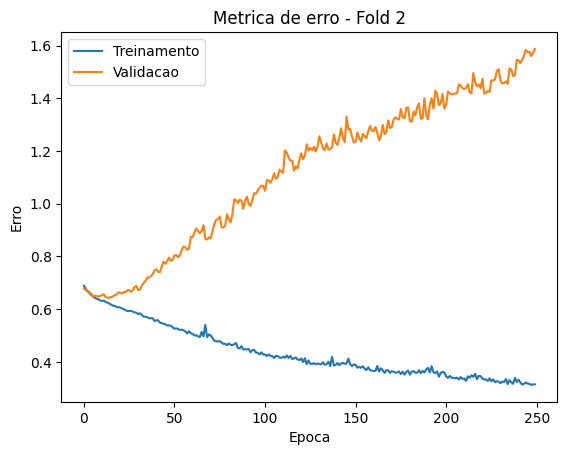

--> Acuracia (treino): 0.8494
--> Acuracia (validacao): 0.5000
--> Ein - Eval = 0.3494
--> val_loss - train_loss = 1.2722

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5281 - loss: 0.6946 - val_accuracy: 0.4524 - val_loss: 0.6893
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6135 - loss: 0.6794 - val_accuracy: 0.4762 - val_loss: 0.6987
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5545 - loss: 0.6667 - val_accuracy: 0.4286 - val_loss: 0.7079
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5894 - loss: 0.6555 - val_accuracy: 0.4286 - val_loss: 0.7110
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5943 - loss: 0.6524 - val_accuracy: 0.4524 - val_loss: 0.7114
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5934 - loss: 0.6502 - val_accuracy: 0.4524 - val_loss: 0.7045
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6036 - loss: 0.6389 - val_accuracy: 0.5000 - val_loss: 0.

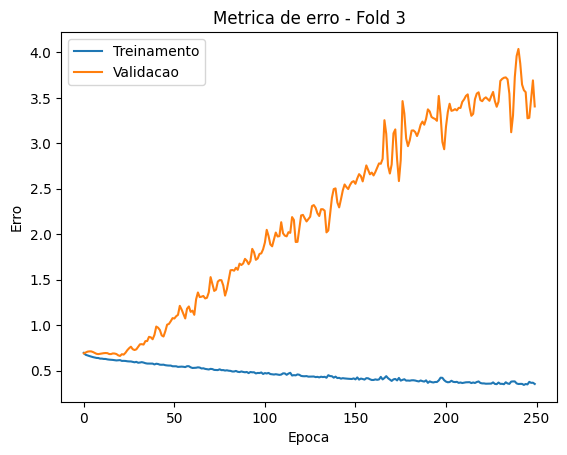

--> Acuracia (treino): 0.8373
--> Acuracia (validacao): 0.4524
--> Ein - Eval = 0.3850
--> val_loss - train_loss = 3.0529

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5274 - loss: 0.6940 - val_accuracy: 0.5610 - val_loss: 0.7019
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6194 - loss: 0.6805 - val_accuracy: 0.6098 - val_loss: 0.6866
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6206 - loss: 0.6699 - val_accuracy: 0.5366 - val_loss: 0.6775
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5840 - loss: 0.6641 - val_accuracy: 0.5122 - val_loss: 0.6764
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6110 - loss: 0.6526 - val_accuracy: 0.5366 - val_loss: 0.6796
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6199 - loss: 0.6407 - val_accuracy: 0.5366 - val_loss: 0.6931
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5890 - loss: 0.6391 - val_accuracy: 0.5122 - val_loss: 0.7052

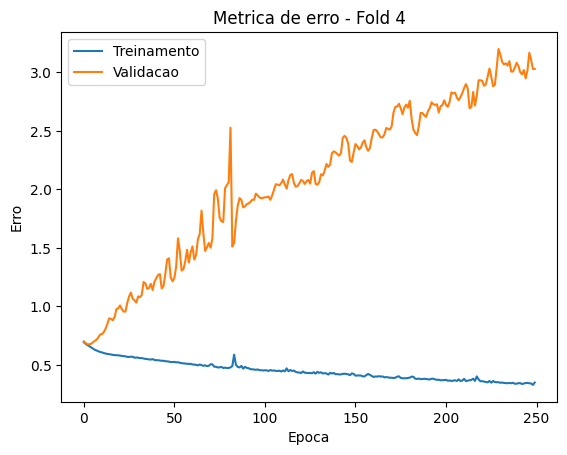

--> Acuracia (treino): 0.8443
--> Acuracia (validacao): 0.5366
--> Ein - Eval = 0.3077
--> val_loss - train_loss = 2.6803

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5295 - loss: 0.6899 - val_accuracy: 0.6585 - val_loss: 0.6880
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5137 - loss: 0.6743 - val_accuracy: 0.5854 - val_loss: 0.6874
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5619 - loss: 0.6705 - val_accuracy: 0.5854 - val_loss: 0.6848
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5390 - loss: 0.6585 - val_accuracy: 0.6098 - val_loss: 0.6820
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5522 - loss: 0.6545 - val_accuracy: 0.5854 - val_loss: 0.6780
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5797 - loss: 0.6511 - val_accuracy: 0.5854 - val_loss: 0.6715
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5784 - loss: 0.6424 - val_accuracy: 0.6098 - val_loss: 0.66

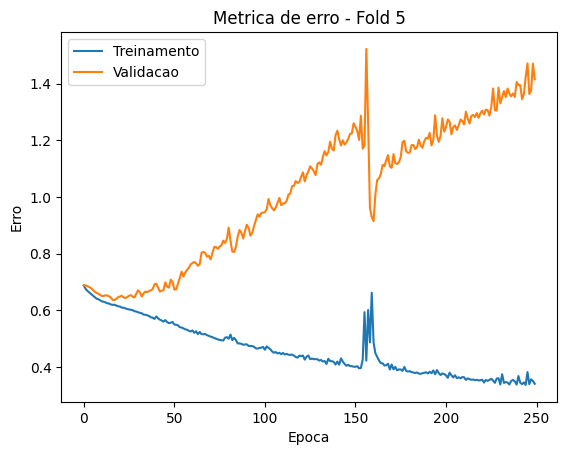

--> Acuracia (treino): 0.8383
--> Acuracia (validacao): 0.5610
--> Ein - Eval = 0.2773
--> val_loss - train_loss = 1.0754



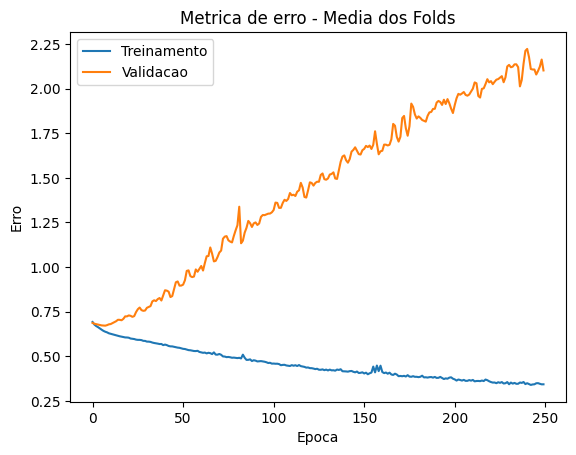

--> Acuracia media (treino): 0.8450
--> Acuracia media (validacao): 0.5243
--> acc_in - acc_val = 0.3207
--> loss medio do treino = 0.4557
--> loss medio da validacao = 1.4462
--> val_loss - train_loss = 0.9905



In [61]:
# A ideia é forçar o overfitting para tentar aumentar a acurácia no treino, ao menos ver se isso é possível
# Introduzindo o k-fold, com k=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accuracies_train = []
accuracies_val = []
history_list = []
tamanho_history_history_loss_list = []
i = 0
for index_treino, index_val in kfold.split(X_train, Y_train):
    i += 1
    X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
    Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

    # Criando a rede neural
    model = Sequential()
    # Adicionando neurônios em uma camada oculta
    model.add(Dense(200, input_dim=10, kernel_initializer='normal', activation='relu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(200, input_dim=10, kernel_initializer='normal', activation='relu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

    # adicionando a taxa de aprendizado
    learning_rate = 0.001  

    # Criando um otimizador Adam com a taxa de aprendizado desejada
    otimizador = optimizers.Adam(learning_rate=learning_rate)

    # Compilando o modelo
    model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])


    #Treinando o modelo
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=1)
    history_list.append(history)
    tamanho_history_history_loss_list.append(len(history.history['loss']))

    # Avalia o modelo
    _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)

    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento', 'Validacao'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
    print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
       

# Calcula a acuracia media
acuracia_media_treino = np.mean(accuracies_train)
acuracia_media_validacao = np.mean(accuracies_val)

# Historico com valores medios dos folds
history_train_loss_avg_list = []
history_val_losso_avg_list = []

for epoca in range(max(tamanho_history_history_loss_list)):
    list_valores_loss_train = []
    list_valores_loss_val = []
    for j in range(len(history_list)):
        if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
            list_valores_loss_train.append(history_list[j].history['loss'][epoca])
            list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
    history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
    history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

loss_medio_treino = np.mean(history_train_loss_avg_list)
loss_medio_val = np.mean(history_val_losso_avg_list)

plt.plot(history_train_loss_avg_list)
plt.plot(history_val_losso_avg_list)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

- Ocorreu um aumento da acurácia do treino para 84%, consideravelmente melhor que o anterior. Entretanto, o overfitting está bastante elevado.

# Tratando o overfitting do primeiro K-fold, com 2 neurônios e uma camada oculta

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 195: early stopping


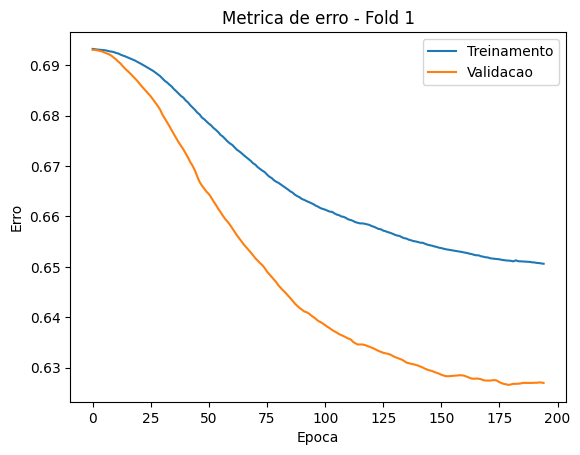

--> Acuracia (treino): 0.5602
--> Acuracia (validacao): 0.6190
--> Ein - Eval = -0.0588
--> val_loss - train_loss = -0.0236

Epoch 225: early stopping


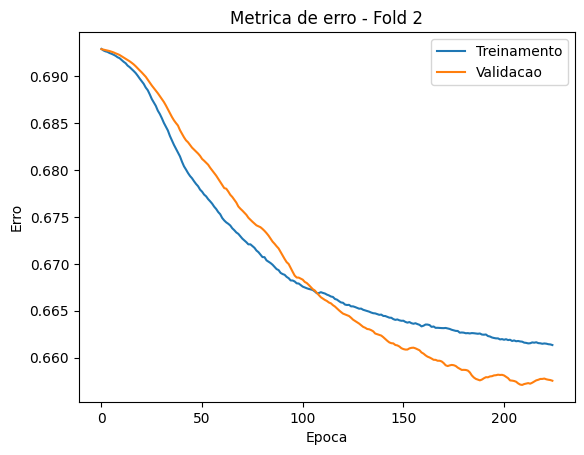

--> Acuracia (treino): 0.5723
--> Acuracia (validacao): 0.5952
--> Ein - Eval = -0.0229
--> val_loss - train_loss = -0.0038

Epoch 36: early stopping


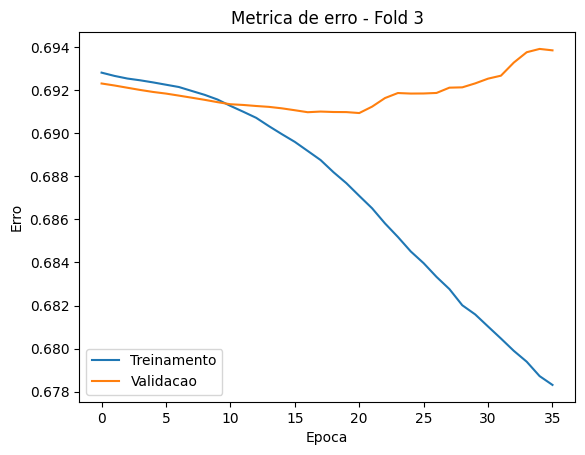

--> Acuracia (treino): 0.5602
--> Acuracia (validacao): 0.4286
--> Ein - Eval = 0.1317
--> val_loss - train_loss = 0.0155

Epoch 50: early stopping


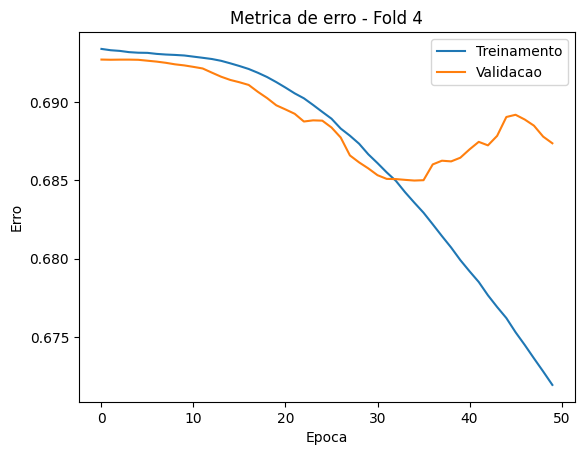

--> Acuracia (treino): 0.5749
--> Acuracia (validacao): 0.5122
--> Ein - Eval = 0.0627
--> val_loss - train_loss = 0.0155

Epoch 195: early stopping


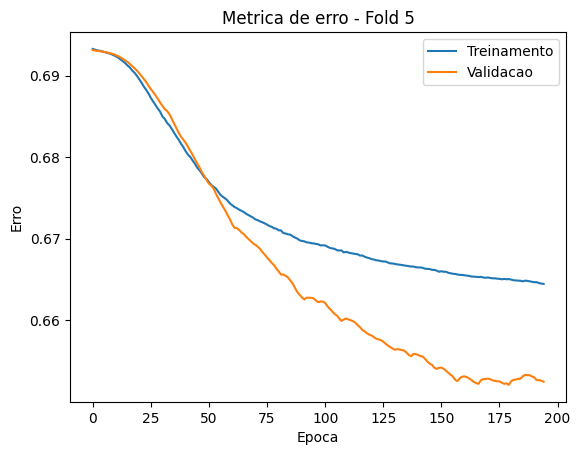

--> Acuracia (treino): 0.5629
--> Acuracia (validacao): 0.6341
--> Ein - Eval = -0.0713
--> val_loss - train_loss = -0.0120



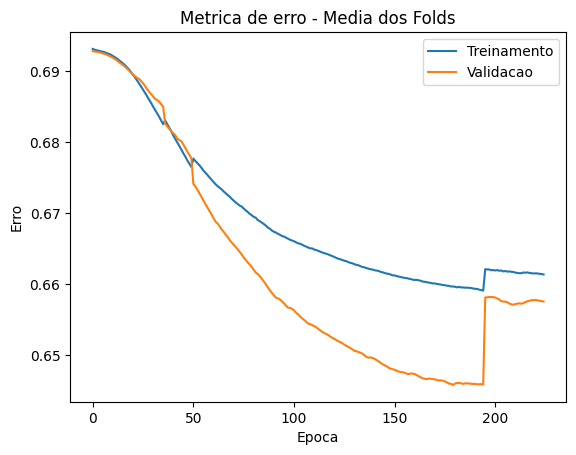

--> Acuracia media (treino): 0.5661
--> Acuracia media (validacao): 0.5578
--> acc_in - acc_val = 0.0083
--> loss medio do treino = 0.6694
--> loss medio da validacao = 0.6621
--> val_loss - train_loss = -0.0073



In [70]:
# Introduzindo o k-fold, com k=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accuracies_train = []
accuracies_val = []
history_list = []
tamanho_history_history_loss_list = []
i = 0
for index_treino, index_val in kfold.split(X_train, Y_train):
    i += 1
    X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
    Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

    # Criando a rede neural
    model = Sequential()
    # Adicionando neurônios em uma camada oculta
    model.add(Dense(2, input_dim=10, kernel_initializer='normal', activation='gelu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

    # adicionando a taxa de aprendizado
    learning_rate = 0.001  

    # Criando um otimizador Adam com a taxa de aprendizado desejada
    otimizador = optimizers.Adam(learning_rate=learning_rate)

    # Adicionando uma condição de parada
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

    # Compilando o modelo
    model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])


    #Treinando o modelo
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, verbose = 0, batch_size=BATCH_SIZE, callbacks= [es])
    history_list.append(history)
    tamanho_history_history_loss_list.append(len(history.history['loss']))

    # Avalia o modelo
    _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)

    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento', 'Validacao'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
    print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
       

# Calcula a acuracia media
acuracia_media_treino = np.mean(accuracies_train)
acuracia_media_validacao = np.mean(accuracies_val)

# Historico com valores medios dos folds
history_train_loss_avg_list = []
history_val_losso_avg_list = []

for epoca in range(max(tamanho_history_history_loss_list)):
    list_valores_loss_train = []
    list_valores_loss_val = []
    for j in range(len(history_list)):
        if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
            list_valores_loss_train.append(history_list[j].history['loss'][epoca])
            list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
    history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
    history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

loss_medio_treino = np.mean(history_train_loss_avg_list)
loss_medio_val = np.mean(history_val_losso_avg_list)

plt.plot(history_train_loss_avg_list)
plt.plot(history_val_losso_avg_list)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

# Tratando o overfitting da rede com 200 neurônios

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 53: early stopping


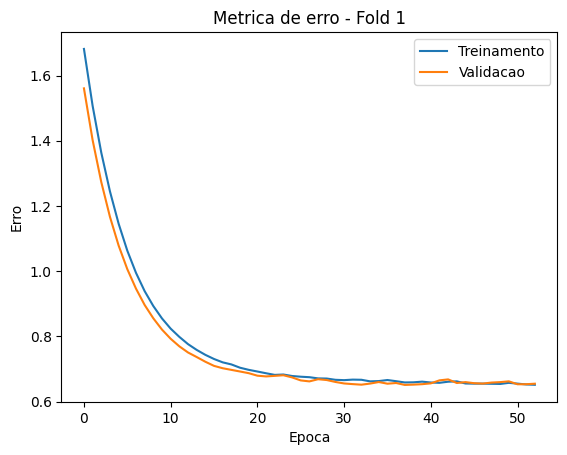

--> Acuracia (treino): 0.6446
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.0731
--> val_loss - train_loss = 0.0033

Epoch 85: early stopping


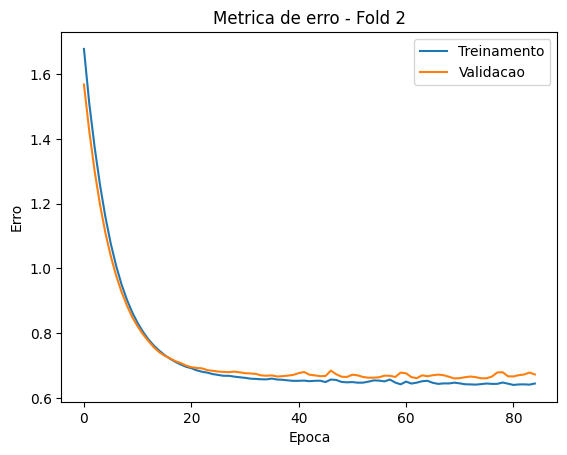

--> Acuracia (treino): 0.6145
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.0430
--> val_loss - train_loss = 0.0280

Epoch 82: early stopping


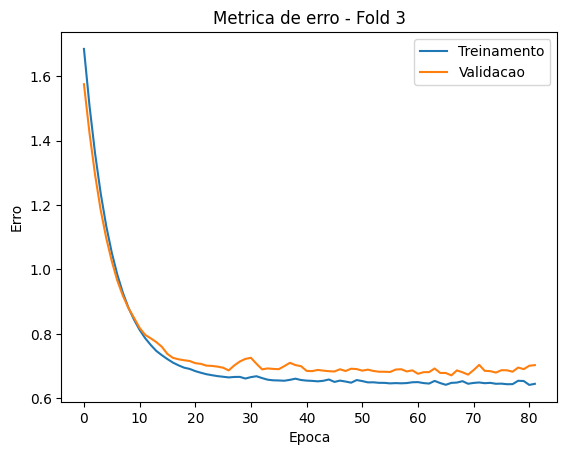

--> Acuracia (treino): 0.5964
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.0250
--> val_loss - train_loss = 0.0580

Epoch 39: early stopping


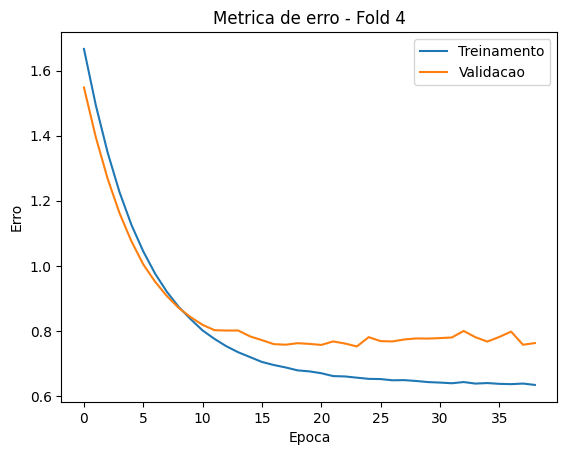

--> Acuracia (treino): 0.6287
--> Acuracia (validacao): 0.5122
--> Ein - Eval = 0.1165
--> val_loss - train_loss = 0.1286

Epoch 79: early stopping


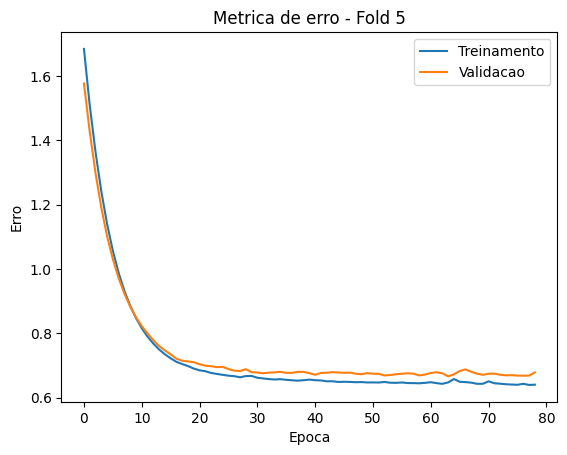

--> Acuracia (treino): 0.6168
--> Acuracia (validacao): 0.5854
--> Ein - Eval = 0.0314
--> val_loss - train_loss = 0.0381



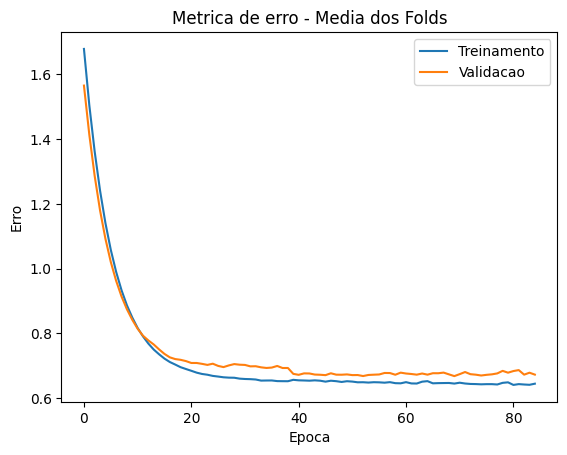

--> Acuracia media (treino): 0.6202
--> Acuracia media (validacao): 0.5624
--> acc_in - acc_val = 0.0578
--> loss medio do treino = 0.7230
--> loss medio da validacao = 0.7417
--> val_loss - train_loss = 0.0187



In [75]:
# A ideia é forçar o overfitting para tentar aumentar a acurácia no treino, ao menos ver se isso é possível
# Introduzindo o k-fold, com k=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
accuracies_train = []
accuracies_val = []
history_list = []
tamanho_history_history_loss_list = []
i = 0
for index_treino, index_val in kfold.split(X_train, Y_train):
    i += 1
    X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
    Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

    # Criando a rede neural
    model = Sequential()
    # Adicionando neurônios em uma camada oculta
    model.add(Dense(200, input_dim=10, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(200, input_dim=10, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu')) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

    # adicionando a taxa de aprendizado
    learning_rate = 0.001  

    # Criando um otimizador Adam com a taxa de aprendizado desejada
    otimizador = optimizers.Adam(learning_rate=learning_rate)

    # Compilando o modelo
    model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])

    # Adicionando uma condição de parada
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

    #Treinando o modelo
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
    history_list.append(history)
    tamanho_history_history_loss_list.append(len(history.history['loss']))

    # Avalia o modelo
    _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)

    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento', 'Validacao'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
    print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
       

# Calcula a acuracia media
acuracia_media_treino = np.mean(accuracies_train)
acuracia_media_validacao = np.mean(accuracies_val)

# Historico com valores medios dos folds
history_train_loss_avg_list = []
history_val_losso_avg_list = []

for epoca in range(max(tamanho_history_history_loss_list)):
    list_valores_loss_train = []
    list_valores_loss_val = []
    for j in range(len(history_list)):
        if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
            list_valores_loss_train.append(history_list[j].history['loss'][epoca])
            list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
    history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
    history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

loss_medio_treino = np.mean(history_train_loss_avg_list)
loss_medio_val = np.mean(history_val_losso_avg_list)

plt.plot(history_train_loss_avg_list)
plt.plot(history_val_losso_avg_list)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

- Redução na diferença de acurácia do treino e da validação, mas ainda existe 6% de discrepância. As perdas se aproximaram, mas continuam bastante altas.

# Criando a rede neural final

- Com 2 camadas ocultas e 200 neurônios por camada, usando a função de ativação "relu", obtivemos uma acurácia na validação de 56%
- Com uma camada oculta e dois neurônios, usando a função de ativação "gelu", obtivemos uma acurácia na validação de 55%

In [78]:
# Criando a rede neural
model = Sequential()
# Adicionando as camadas e os neurônios em cada camada
model.add(Dense(2, input_dim=10, kernel_initializer='normal' ,activation='gelu')) #quantidade de neuronios na camada escondida, nº de features
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

# Taxa de aprendizado do otimizador
learning_rate = 0.001

# Criando um otimizador Adam com a taxa de aprendizado
otimizador = optimizers.Adam(learning_rate=learning_rate)

# Adicionando uma condição de parada Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Compilando o modelo
model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])

In [79]:
# Treinando o modelo
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=250, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4719 - loss: 0.6933 - val_accuracy: 0.5385 - val_loss: 0.6933
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4847 - loss: 0.6933 - val_accuracy: 0.5385 - val_loss: 0.6932
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4932 - loss: 0.6932 - val_accuracy: 0.5385 - val_loss: 0.6931
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4928 - loss: 0.6932 - val_accuracy: 0.5385 - val_loss: 0.6931
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5099 - loss: 0.6931 - val_accuracy: 0.5385 - val_loss: 0.6930
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4964 - loss: 0.6932 - val_accuracy: 0.5385 - val_loss: 0.6930
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5141 - loss: 0.6930 - val_accuracy: 0.5385 - val_loss: 0.6929
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5111 - loss: 0.6929 - val_accuracy: 0.5385 - val_loss: 0.69

--> Acuracia (treino): 0.5962
--> Acuracia (validacao): 0.7115
--> Ein - Eval = -0.1154
--> val_loss - train_loss = -0.0064



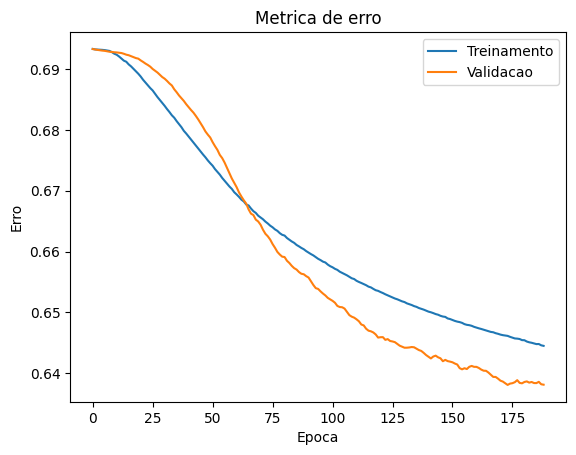

In [80]:
# Calculando a acuracia
_, accuracy_train = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
_, accuracy_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)

# Plotando os resultados
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])


print(f'--> Acuracia (treino): {accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")

In [81]:
# Avaliando o modelo com o classification report
Y_pred_train = np.round(model.predict(X_train))
print('Classification Report (treino):')
print(classification_report(Y_train, Y_pred_train))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report (treino):
              precision    recall  f1-score   support

           0       0.61      0.51      0.56       103
           1       0.59      0.68      0.63       105

    accuracy                           0.60       208
   macro avg       0.60      0.60      0.59       208
weighted avg       0.60      0.60      0.59       208



In [82]:
Y_pred_val = np.round(model.predict(X_val))
print('Classification Report (validacao):')
print(classification_report(Y_val, Y_pred_val))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report (validacao):
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        24
           1       0.74      0.71      0.73        28

    accuracy                           0.71        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.71      0.71      0.71        52



# Obtendo as métricas do teste

In [ ]:
"""Y_pred_test = np.round(model.predict(X_test))
print('Classification Report (teste):')
print(classification_report(Y_test, Y_pred_test))
unique, counts = np.unique(Y_test, return_counts=True)
print("Quantidade de amostras de cada classe: ", dict(zip(unique, counts)))
unique, counts = np.unique(Y_pred_test, return_counts=True)
print("Quantidade de amostras previstas de cada classe: ", dict(zip(unique, counts)))"""